In [ ]:
import pandas as pd
import plotly.express as px
import umap
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from functions.common_functions import *

In [2]:
df = pd.read_csv('../data/processed/CPA-virtual_database.csv')
df_training = df[df['Rxn_Type'] == 'Training']
df_training_rxns = df_training['rxn']
df_virtual = df[df['Rxn_Type'] == 'Virtual']
df_virtual = df_virtual[df_virtual['Catalyst_Ar_grp'] == 'L15']
df_virtual = df_virtual.reset_index(drop=True)

df_virtual_pred = pd.read_csv('../data/processed/CPA_virtual_clusters_predictions.csv')


In [3]:
## Initial Processing ##

vt = VarianceThreshold()

parameters = df_virtual.iloc[:,9:] ## Set parameters to desired columns ##
thres = vt.fit(parameters)
parameters = thres.transform(parameters)

scaled_data = StandardScaler().fit_transform(parameters)

In [4]:
## Clustering Embedding ##

num_reactions = len(df_virtual)

reducer = umap.UMAP(
    random_state=25,
    min_dist=0,  # Default is 0.1
    n_neighbors=num_reactions/2,  # Default is 15
    n_components=10)

clustering_embedding = reducer.fit_transform(scaled_data)

## Elbow Plot ##

range_, inertia = get_clusters(clustering_embedding,100)

fig = px.scatter(x=range_, y=inertia,
                labels={'x':'# of Clusters', 'y':'Inertia'},
                template='simple_white'
                )

fig.update_traces(marker=dict(size=17,
                              line=dict(width=2,
                                        color='Black')),
                  selector=dict(mode='markers'))

fig.update_xaxes(mirror=True)
fig.update_yaxes(mirror=True)

fig.update_layout(
    font_size=20,
)

fig.show()

In [25]:
## Impact of Random Seed on Generality ##
random_seed_list = []
cat_list = []
gen_list = []

for i in range(1,1000):
    labels = list(k_cluster(clustering_embedding,50,init=i))*len(df_training['Catalyst_Ar_grp'].unique())
    cats = df['Catalyst_Ar_grp'].unique()

    for cat in cats:
        generality, clusters, cluster_ee = calc_generality(df_virtual_pred,cat,'Catalyst_Ar_grp','Predicted ee', labels, 60)
        cat_list.append(cat)
        gen_list.append(generality)


random_seed_generality = pd.DataFrame({'catalyst':cat_list,'generality':gen_list})
random_seed_generality = random_seed_generality.replace({'L1':'Ph','L2':'4-NO2C6H4','L4':'4-ClC6H4','L5':'4-PhC6H4', 
                                                        'L6':'4-CF3C6H4', 'L7':'3,5-NO2C6H3', 'L8':'3,5-PhC6H3',
                                                        'L9':'3,5-(CF3)2-C6H3','L10':'9-Anthryl','L11':'9-Phenanthryl',
                                                        'L12': '1-naphthyl','L13': '2-naphthyl','L14':'2,4,6-iPrC6H2',
                                                        'L15':'2,4,6-MeC6H2','L16':'2,6-MeC6H2'})

random_seed_generality = random_seed_generality.set_index('catalyst')

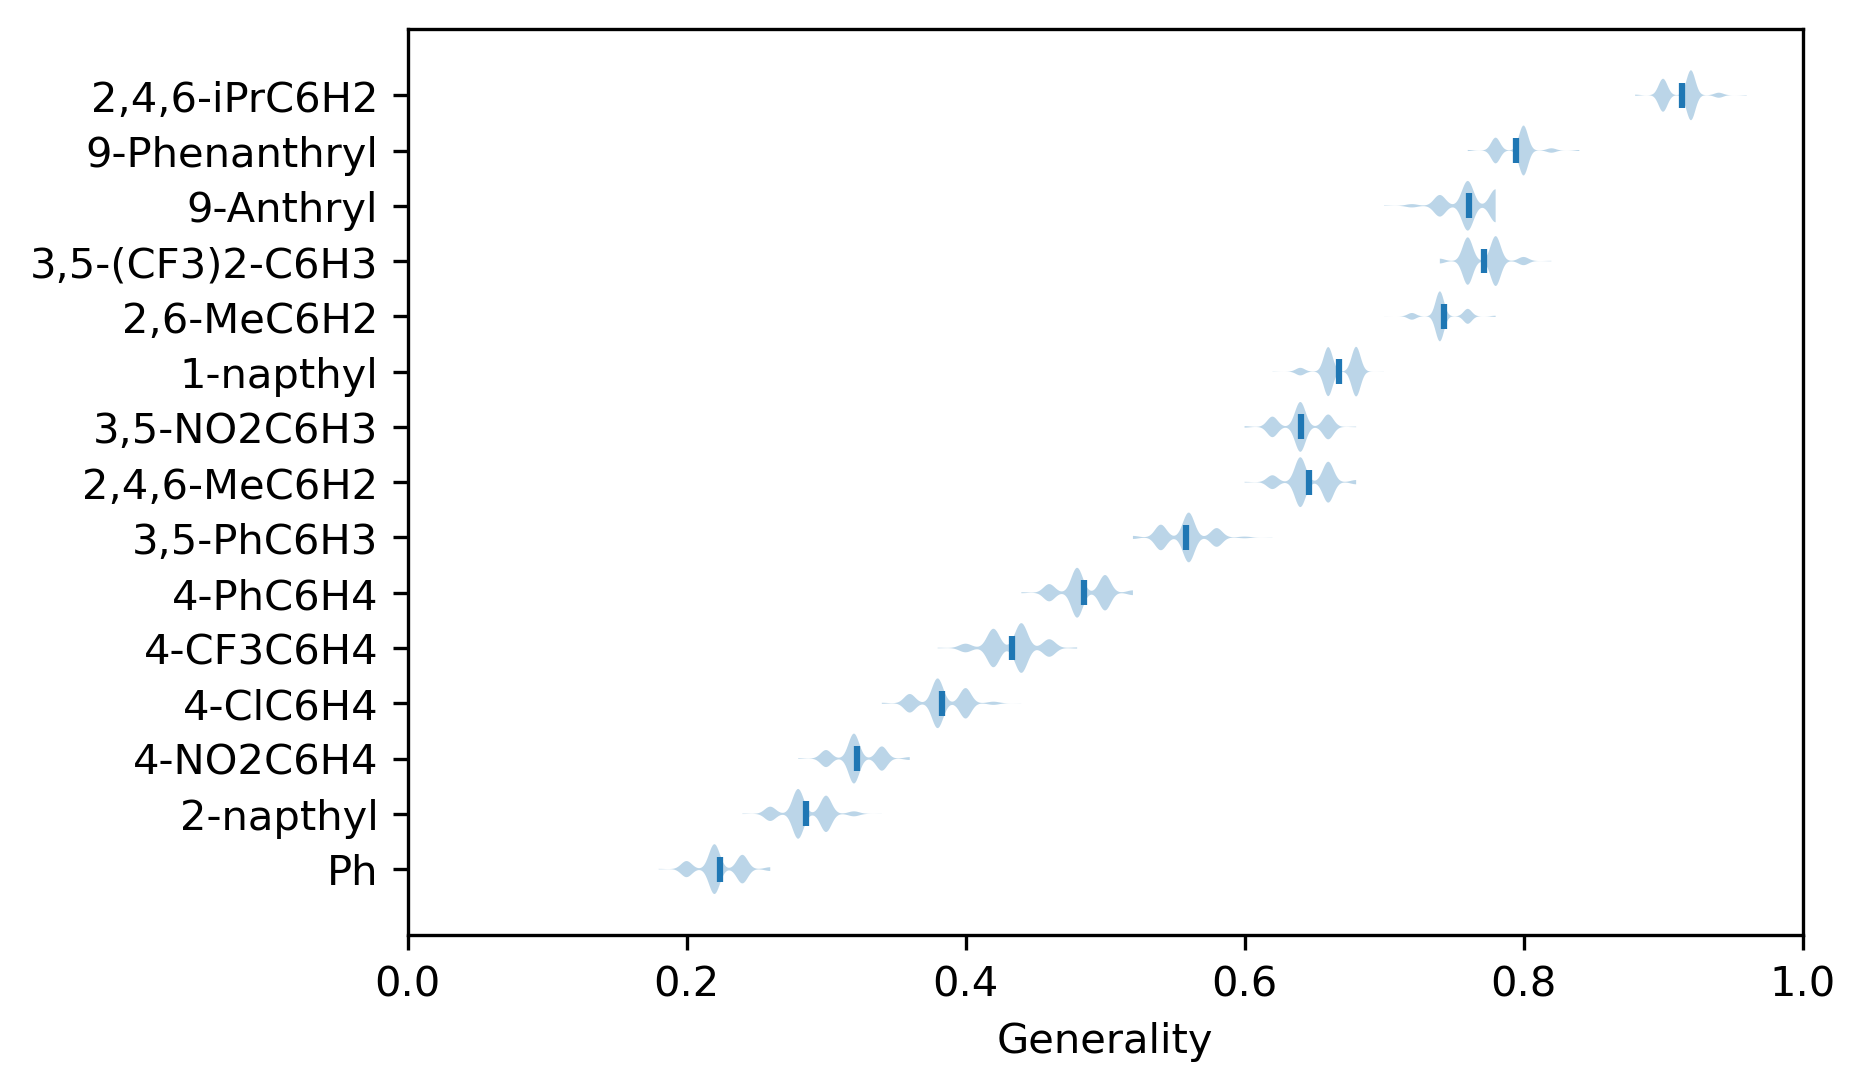

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.violinplot([random_seed_generality.loc['Ph','generality'],random_seed_generality.loc['2-naphthyl','generality'],random_seed_generality.loc['4-NO2C6H4','generality'],
                random_seed_generality.loc['4-ClC6H4','generality'],random_seed_generality.loc['4-CF3C6H4','generality'],random_seed_generality.loc['4-PhC6H4','generality'],
                random_seed_generality.loc['3,5-PhC6H3','generality'],random_seed_generality.loc['2,4,6-MeC6H2','generality'],random_seed_generality.loc['3,5-NO2C6H3','generality'],
                random_seed_generality.loc['1-naphthyl','generality'],random_seed_generality.loc['2,6-MeC6H2','generality'],random_seed_generality.loc['3,5-(CF3)2-C6H3','generality'],
                random_seed_generality.loc['9-Anthryl','generality'],random_seed_generality.loc['9-Phenanthryl','generality'],random_seed_generality.loc['2,4,6-iPrC6H2','generality']
                ], showmeans=True, showextrema=False, widths=0.9, vert=False)               

fig.set_dpi(300)
ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
ax.set_yticklabels(['Ph','2-napthyl','4-NO2C6H4','4-ClC6H4','4-CF3C6H4','4-PhC6H4','3,5-PhC6H3','2,4,6-MeC6H2','3,5-NO2C6H3','1-napthyl','2,6-MeC6H2','3,5-(CF3)2-C6H3','9-Anthryl',
                    '9-Phenanthryl','2,4,6-iPrC6H2'])
# plt.xticks(rotation=45)
plt.xlabel('Generality')
plt.xlim(0,1)
plt.show()